# Fit CoFactor model for CVS Using Global Cooccurrence

In [2]:
import itertools
import glob
import os
import sys
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from scipy import sparse
import seaborn as sns
sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

In [3]:
import cofacto
import rec_eval

### Construct the positive pairwise mutual information (PPMI) matrix

Change this to wherever you saved the pre-processed data following [this notebook](./preprocess_ML20M.ipynb).

In [4]:
DATA_DIR = '/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro'

In [5]:
unique_uid = list()
with open(os.path.join(DATA_DIR, 'unique_uid.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
    
unique_sid = list()
with open(os.path.join(DATA_DIR, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

In [6]:
unique_sid

['1-1-1-1',
 '1-1-12-12',
 '1-1-13-13',
 '1-1-14-14',
 '1-1-15-15',
 '1-1-18-10',
 '1-1-18-16',
 '1-1-18-17',
 '1-1-18-18',
 '1-1-18-20',
 '1-1-18-32',
 '1-1-18-33',
 '1-1-19-19',
 '1-1-2-2',
 '1-1-3-3',
 '1-1-30-30',
 '1-1-32-24',
 '1-1-4-4',
 '1-1-5-31',
 '1-1-6-5',
 '1-1-7-7',
 '1-1-8-6',
 '1-1-9-9',
 '1-11-12-12',
 '1-11-13-11',
 '1-11-13-13',
 '1-11-13-14',
 '1-11-13-15',
 '1-11-3-1',
 '1-11-3-2',
 '1-11-3-27',
 '1-11-3-28',
 '1-11-3-3',
 '1-11-3-9',
 '1-11-4-30',
 '1-11-5-16',
 '1-11-5-24',
 '1-11-5-4',
 '1-11-5-5',
 '1-11-6-6',
 '1-11-8-10',
 '1-11-8-22',
 '1-11-8-8',
 '1-12-1-10',
 '1-12-1-11',
 '1-12-1-12',
 '1-12-1-14',
 '1-12-1-9',
 '1-12-17-17',
 '1-12-17-2',
 '1-12-17-4',
 '1-12-17-7',
 '1-12-17-8',
 '1-12-18-18',
 '1-12-2-41',
 '1-12-3-13',
 '1-12-3-15',
 '1-12-3-24',
 '1-12-3-25',
 '1-12-3-3',
 '1-12-3-40',
 '1-12-4-42',
 '1-12-5-5',
 '1-15-1-1',
 '1-15-10-10',
 '1-15-11-2',
 '1-15-11-4',
 '1-15-12-12',
 '1-15-5-5',
 '1-15-8-8',
 '1-15-9-9',
 '1-17-1-1',
 '1-17-1-3',
 '1

In [7]:
n_items = len(unique_sid)
n_users = len(unique_uid)

print(n_users, n_items)

15413 2036


In [8]:
def load_data(csv_file, shape=(n_users, n_items)):
    tp = pd.read_csv(csv_file)
    timestamps, rows, cols = np.array(tp['timestamp']), np.array(tp['uid']), np.array(tp['sid'])
    seq = np.concatenate((rows[:, None], cols[:, None], np.ones((rows.size, 1), dtype='int'), timestamps[:, None]), axis=1)
    data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int16, shape=shape)
    return data, seq

In [9]:
train_data, train_raw = load_data(os.path.join(DATA_DIR, 'train.csv'))

In [10]:
print(train_data)

  (0, 28)	1
  (0, 167)	4
  (0, 176)	1
  (0, 215)	1
  (0, 221)	1
  (0, 236)	1
  (0, 396)	1
  (0, 422)	1
  (0, 426)	1
  (0, 616)	1
  (0, 1211)	2
  (0, 1248)	1
  (0, 1258)	1
  (0, 1294)	1
  (0, 1303)	1
  (0, 1614)	1
  (0, 1641)	2
  (0, 1726)	2
  (0, 1934)	3
  (0, 1954)	1
  (1, 1)	1
  (1, 68)	1
  (1, 73)	1
  (1, 126)	1
  (1, 157)	1
  :	:
  (15412, 581)	1
  (15412, 588)	1
  (15412, 614)	2
  (15412, 619)	2
  (15412, 623)	1
  (15412, 762)	1
  (15412, 1058)	1
  (15412, 1067)	1
  (15412, 1152)	1
  (15412, 1166)	3
  (15412, 1264)	1
  (15412, 1271)	10
  (15412, 1276)	1
  (15412, 1285)	1
  (15412, 1638)	1
  (15412, 1641)	1
  (15412, 1726)	1
  (15412, 1757)	1
  (15412, 1776)	1
  (15412, 1800)	1
  (15412, 1878)	2
  (15412, 1915)	1
  (15412, 1984)	1
  (15412, 1992)	1
  (15412, 2000)	1


In [11]:
train_raw

array([[     13282,        377,          1, 1517596500],
       [      6722,       1180,          1, 1517598960],
       [      6722,       1277,          1, 1517598960],
       ...,
       [      5459,       1552,          1, 1535461200],
       [      1371,       1669,          1, 1542446760],
       [     14477,        322,          1, 1542550020]])

In [12]:
purchase_per_item = np.asarray(train_data.astype('int64').sum(axis=0)).ravel()

In [13]:
len(purchase_per_item)

2036

In [14]:
print("The mean (median)  per item is %d (%d)" % (purchase_per_item.mean(), np.median(purchase_per_item)))

The mean (median)  per item is 538 (130)


In [15]:
user_activity = np.asarray(train_data.sum(axis=1)).ravel()

In [16]:
print("The mean (median) items each user purchased in one transaction is %d (%d)" % (user_activity.mean(), np.median(user_activity)))



The mean (median) items each user purchased in one transaction is 71 (49)


In [17]:
n_items = len(unique_sid)
n_users = len(unique_uid)

print(n_users, n_items)

15413 2036


In [18]:
vad_data, vad_raw = load_data(os.path.join(DATA_DIR, 'validation.csv'))

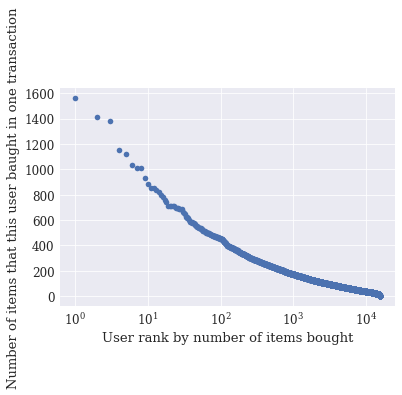

In [19]:
plt.semilogx(1 + np.arange(n_users), -np.sort(-user_activity), 'o')
plt.ylabel('Number of items that this user baught in one transaction')
plt.xlabel('User rank by number of items bought')
pass

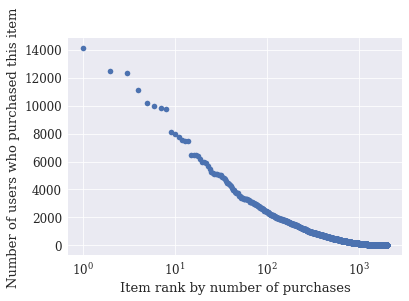

In [20]:
plt.semilogx(1 + np.arange(n_items), -np.sort(-purchase_per_item), 'o')
plt.ylabel('Number of users who purchased this item')
plt.xlabel('Item rank by number of purchases')
pass

### Generate Global co-occurrence matrix

In [21]:
train_raw

array([[     13282,        377,          1, 1517596500],
       [      6722,       1180,          1, 1517598960],
       [      6722,       1277,          1, 1517598960],
       ...,
       [      5459,       1552,          1, 1535461200],
       [      1371,       1669,          1, 1542446760],
       [     14477,        322,          1, 1542550020]])

In [22]:
def _coord_batch(lo, hi, train_data):
    rows = []
    cols = []
    for u in range(lo, hi):
        for w, c in itertools.permutations(train_data[u].nonzero()[1], 2):
            rows.append(w)
            cols.append(c)
    np.save(os.path.join(DATA_DIR, 'coo_%d_%d.npy' % (lo, hi)),
            np.concatenate([np.array(rows)[:, None], np.array(cols)[:, None]], axis=1))
    pass

In [23]:
from joblib import Parallel, delayed

batch_size = 5000

start_idx = range(0, n_users, batch_size)
end_idx = list(start_idx[1:]) + [n_users]

Parallel(n_jobs=8)(delayed(_coord_batch)(lo, hi, train_data) for lo, hi in zip(start_idx, end_idx))
pass

In [24]:
X = sparse.csr_matrix((n_items, n_items), dtype='float32')

for lo, hi in zip(start_idx, end_idx):
    coords = np.load(os.path.join(DATA_DIR, 'coo_%d_%d.npy' % (lo, hi)))
    
    rows = coords[:, 0]
    cols = coords[:, 1]
    
    tmp = sparse.coo_matrix((np.ones_like(rows), (rows, cols)), shape=(n_items, n_items), dtype='float32').tocsr()
    X = X + tmp
    
    print("User %d to %d finished" % (lo, hi))
    sys.stdout.flush()

User 0 to 5000 finished
User 5000 to 10000 finished
User 10000 to 15000 finished
User 15000 to 15413 finished


Note: Don't forget to delete all the temporary coo_LO_HI.npy files

In [25]:
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_data.npy'), X.data)
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_indices.npy'), X.indices)
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_indptr.npy'), X.indptr)

In [26]:
1-float(X.nnz) / np.prod(X.shape)

0.48226761128758955

### Or load the pre-saved co-occurrence matrix

In [27]:
# or co-occurrence matrix from the entire user history
dir_predix = DATA_DIR

In [28]:
data = np.load(os.path.join(dir_predix, 'coordinate_co_binary_data.npy'))
indices = np.load(os.path.join(dir_predix, 'coordinate_co_binary_indices.npy'))
indptr = np.load(os.path.join(dir_predix, 'coordinate_co_binary_indptr.npy'))

In [29]:
X = sparse.csr_matrix((data, indices, indptr), shape=(n_items, n_items))

In [30]:
print(X.shape)

(2036, 2036)


In [31]:
1-float(X.nnz) / np.prod(X.shape)

0.48226761128758955

In [32]:
def get_row(Y, i):
    lo, hi = Y.indptr[i], Y.indptr[i + 1]
    return lo, hi, Y.data[lo:hi], Y.indices[lo:hi]

In [33]:
count = np.asarray(X.sum(axis=1)).ravel()

In [34]:
count

array([102460.,  59499., 115104., ...,    127.,    432.,  28042.],
      dtype=float32)

In [35]:
n_pairs = X.data.sum()

In [36]:
n_pairs

35760496.0

### Construct the SPPMI matrix

In [37]:
M = X.copy()

for i in range(n_items):
    lo, hi, d, idx = get_row(M, i)
    M.data[lo:hi] = np.log(d * n_pairs / (count[i] * count[idx]))

In [38]:
M.data[M.data < 0] = 0
M.eliminate_zeros()

In [39]:
1-float(M.nnz) / np.prod(M.shape)

0.7070279179098429

Now $M$ is the PPMI matrix. Depending on the number of negative examples $k$, we can obtain the shifted PPMI matrix as $\max(M_{wc} - \log k, 0)$

In [40]:
# number of negative samples
k_ns = 1

M_ns = M.copy()

if k_ns > 1:
    offset = np.log(k_ns)
else:
    offset = 0.
    
M_ns.data -= offset
M_ns.data[M_ns.data < 0] = 0
M_ns.eliminate_zeros()

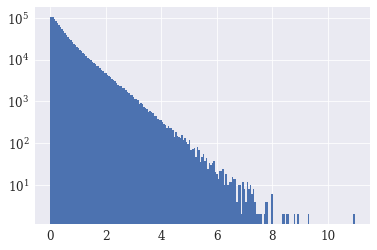

In [41]:
plt.hist(M_ns.data, bins=200)
plt.yscale('log')
pass

In [42]:
1-float(M_ns.nnz) / np.prod(M_ns.shape)

0.7070279179098429

In [43]:
M_ns.A

array([[0.        , 0.48181263, 0.12042916, ..., 1.0109395 , 1.1729953 ,
        0.        ],
       [0.48181263, 0.        , 0.06316826, ..., 0.        , 0.        ,
        0.        ],
       [0.12042916, 0.06316826, 0.        , ..., 0.        , 0.36348465,
        0.        ],
       ...,
       [1.0109395 , 0.        , 0.        , ..., 0.        , 6.4797416 ,
        0.        ],
       [1.1729953 , 0.        , 0.36348465, ..., 6.4797416 , 0.        ,
        1.7756172 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.7756172 ,
        0.        ]], dtype=float32)

### Train the model

In [44]:
scale = 0.03

n_components = 100
max_iter = 20
n_jobs = 8
lam_theta = lam_beta = 1e-5 * scale
lam_gamma = 1e-5
c0 = 1. * scale
c1 = 10. * scale

save_dir = os.path.join(DATA_DIR, 'ML20M_ns%d_scale%1.2E' % (k_ns, scale))

In [45]:
import cofacto
coder = cofacto.CoFacto(n_components=n_components, max_iter=max_iter, batch_size=1000, init_std=0.01, n_jobs=n_jobs, 
                        random_state=98765, save_params=True, save_dir=save_dir, early_stopping=True, verbose=True, 
                        lam_theta=lam_theta, lam_beta=lam_beta, lam_gamma=lam_gamma, c0=c0, c1=c1)

In [46]:
print(train_data)

  (0, 28)	1
  (0, 167)	4
  (0, 176)	1
  (0, 215)	1
  (0, 221)	1
  (0, 236)	1
  (0, 396)	1
  (0, 422)	1
  (0, 426)	1
  (0, 616)	1
  (0, 1211)	2
  (0, 1248)	1
  (0, 1258)	1
  (0, 1294)	1
  (0, 1303)	1
  (0, 1614)	1
  (0, 1641)	2
  (0, 1726)	2
  (0, 1934)	3
  (0, 1954)	1
  (1, 1)	1
  (1, 68)	1
  (1, 73)	1
  (1, 126)	1
  (1, 157)	1
  :	:
  (15412, 581)	1
  (15412, 588)	1
  (15412, 614)	2
  (15412, 619)	2
  (15412, 623)	1
  (15412, 762)	1
  (15412, 1058)	1
  (15412, 1067)	1
  (15412, 1152)	1
  (15412, 1166)	3
  (15412, 1264)	1
  (15412, 1271)	10
  (15412, 1276)	1
  (15412, 1285)	1
  (15412, 1638)	1
  (15412, 1641)	1
  (15412, 1726)	1
  (15412, 1757)	1
  (15412, 1776)	1
  (15412, 1800)	1
  (15412, 1878)	2
  (15412, 1915)	1
  (15412, 1984)	1
  (15412, 1992)	1
  (15412, 2000)	1


In [47]:
np.savetxt('/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Glob_coo_mat.csv',M_ns.A)

In [48]:
coder.fit(train_data, M_ns, vad_data=vad_data, batch_users=5000, k=100)

ITERATION #0
	Updating user factors: time=0.89
	Updating item factors: time=0.61
	Updating context factors: time=0.37
	Updating bias terms: time=0.32


/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


	Validation NDCG@k: 0.04281
ITERATION #1
	Updating user factors: time=0.63
	Updating item factors: time=0.56
	Updating context factors: time=0.37
	Updating bias terms: time=0.30
	Validation NDCG@k: 0.06235
ITERATION #2
	Updating user factors: time=0.61
	Updating item factors: time=0.58
	Updating context factors: time=0.40
	Updating bias terms: time=0.34
	Validation NDCG@k: 0.06821
ITERATION #3
	Updating user factors: time=0.60
	Updating item factors: time=0.56
	Updating context factors: time=0.38
	Updating bias terms: time=0.31
	Validation NDCG@k: 0.07010
ITERATION #4
	Updating user factors: time=0.59
	Updating item factors: time=0.58
	Updating context factors: time=0.37
	Updating bias terms: time=0.30
	Validation NDCG@k: 0.07078
ITERATION #5
	Updating user factors: time=0.61
	Updating item factors: time=0.57
	Updating context factors: time=0.46
	Updating bias terms: time=0.34
	Validation NDCG@k: 0.07096
ITERATION #6
	Updating user factors: time=0.64
	Updating item factors: time=0.57
	

CoFacto(batch_size=1000, dtype='float32', early_stopping=True, init_std=0.01,
    max_iter=20, n_components=100, n_jobs=8, random_state=98765,
    save_dir='/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/ML20M_ns1_scale3.00E-02',
    save_params=True, verbose=True)

In [49]:
test_data, _ = load_data(os.path.join(DATA_DIR, 'test.csv'))
test_data.data = np.ones_like(test_data.data)

In [50]:
n_params = len(glob.glob(os.path.join(save_dir, '*.npz')))

params = np.load(os.path.join(save_dir, 'CoFacto_K%d_iter%d.npz' % (n_components, n_params - 1)))
U, V = params['U'], params['V']

In [51]:
U.shape

(15413, 100)

In [52]:
V.shape

(2036, 100)

In [53]:
print('Test Recall@20: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=20, vad_data=vad_data))
print('Test Recall@50: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=50, vad_data=vad_data))
print('Test NDCG@100: %.4f' % rec_eval.normalized_dcg_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))
print('Test MAP@100: %.4f' % rec_eval.map_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))

/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:184: RuntimeWarning: invalid value encountered in true_divide
  recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))


Test Recall@20: 0.0485
Test Recall@50: 0.0900


/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


Test NDCG@100: 0.0826
Test MAP@100: 0.0156


In [54]:
np.savez('CoFactor_K100_ML20M.npz', U=U, V=V)

In [55]:
R=U.dot(V.T)

In [56]:
R.shape

(15413, 2036)

In [57]:
R.min()

-18.634748

In [58]:
R.max()

480.38177

In [59]:
train_data.shape

(15413, 2036)

In [60]:
type(train_data)

scipy.sparse.csr.csr_matrix

In [61]:
import scipy

In [62]:
mask=scipy.sparse.random(15413, 2036,density=0.2)

In [319]:
mask = mask.A

In [322]:
mask[mask>0]=1

In [324]:
train_mat=train_data.A

In [329]:
train_mat

480

In [323]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [313]:
above_threshold = train_data >= v[5]

NameError: name 'v' is not defined

In [63]:
seg2id = dict((sid, i) for (i, sid) in enumerate(unique_sid)) 
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [64]:
id2seg = dict((i, sid) for (i, sid) in enumerate(unique_sid))
id2user = dict((i, uid) for (i, uid) in enumerate(unique_uid))

In [65]:
V

array([[-0.02532404, -0.08922536,  0.04356493, ...,  0.03438818,
         0.00996283,  0.04105365],
       [-0.02710998, -0.01189565,  0.00644312, ...,  0.02597229,
        -0.00023421, -0.01962143],
       [-0.05313676, -0.01236115, -0.02490821, ..., -0.04219537,
         0.00477473, -0.03803872],
       ...,
       [ 0.06629349,  0.07928995,  0.02927933, ...,  0.03128941,
         0.00150813,  0.01019382],
       [ 0.05412066,  0.06598525,  0.0254873 , ...,  0.02513798,
         0.00121826,  0.00758045],
       [ 0.00334607, -0.00800595,  0.02236268, ..., -0.01914714,
        -0.03885507, -0.01868969]], dtype=float32)

In [66]:
from sklearn.preprocessing import MinMaxScaler  

In [67]:

#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------
def recommend(original_user_id, data_sparse, user_vecs, item_vecs, user2id, seg2id, id2user, id2seg, num_items=10):
    """Recommend items for a given user given a trained model

    Args:
    user_id (int): The id of the user we want to create recommendations for.

    data_sparse (csr_matrix): Our original training data.

    user_vecs (csr_matrix): The trained user x features vectors

    item_vecs (csr_matrix): The trained item x features vectors

    id2seg (dictionary): Used to map ids to segment names

    num_items (int): How many recommendations we want to return:

    Returns:
    recommendations (pandas.DataFrame): DataFrame with num_items artist names and scores

    """
    user_id = user2id[str(original_user_id)]
    # Get all interactions by the user
    user_interactions = data_sparse[user_id,:].toarray()
 
    # We don't want to recommend items the user has consumed. So let's
    # set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
    user_interactions[user_interactions > 1] = 0
 
    # This is where we calculate the recommendation by taking the
    # dot-product of the user vectors with the item vectors.
    rec_vector = user_vecs[user_id,:].dot(item_vecs.T)
 
    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = rec_vector_scaled
 
    # Get all the segments indices in order of recommendations (descending) and
    # select only the top "num_items" items.
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]
 
    top_n_recommended_items = []
    item_scores = []
 
    # Loop through our recommended segments indicies and look up the actial artist name
    top_n_recommended_items = list(map(lambda x: id2seg[x], item_idx))
    top_n_recommended_items
 

    for item_id in item_idx:
        item_scores.append(recommend_vector[item_id])
 
    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'items': top_n_recommended_items, 'score': item_scores})
 
    return recommendations.sort_values(['score'], ascending=[False])
 



In [68]:
recommendations = recommend(15,train_data,U,V,user2id,seg2id,id2user,id2seg,10)
recommendations

,items,score
0,5-41-1-1,1.000000
1,2-80-4-19,0.957175
2,4-35-3-41,0.487238
3,7-4-1-5,0.479737
4,1-17-17-17,0.449594
5,4-35-3-44,0.443922
6,2-13-4-28,0.420520
7,5-41-41-43,0.420213
8,7-71-6-2,0.417138
9,2-80-2-9,0.416390


In [69]:
user2id['15']

2

In [71]:
items=test_data.A[2].nonzero()

In [72]:
items_v=vad_data.A[2].nonzero()

In [73]:
print(items)

(array([ 578,  853, 1303, 1662, 1788, 1790]),)


In [74]:
type(items)

tuple

In [75]:
items[0]

array([ 578,  853, 1303, 1662, 1788, 1790])

In [76]:
test_i=np.array(list((map(lambda x: id2seg[x], np.array(items[0])))))

In [77]:
print(test_i.reshape(-1,1))

[['2-80-4-19']
 ['3-36-12-13']
 ['4-35-3-41']
 ['5-41-1-1']
 ['7-16-10-11']
 ['7-16-2-2']]


In [78]:
recommendations

,items,score
0,5-41-1-1,1.000000
1,2-80-4-19,0.957175
2,4-35-3-41,0.487238
3,7-4-1-5,0.479737
4,1-17-17-17,0.449594
5,4-35-3-44,0.443922
6,2-13-4-28,0.420520
7,5-41-41-43,0.420213
8,7-71-6-2,0.417138
9,2-80-2-9,0.416390


In [79]:
train_data.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [80]:
test_data.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [81]:
vad_data.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [82]:
total_data=train_data+test_data+vad_data

In [83]:
total_data.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [100]:
training_set = total_data.copy()

In [101]:
nonzero_inds = training_set.nonzero()

In [102]:
nonzero_inds

(array([    0,     0,     0, ..., 15412, 15412, 15412], dtype=int32),
 array([  13,   28,  167, ..., 1984, 1992, 2000], dtype=int32))

In [103]:
nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

In [104]:
nonzero_pairs

[(0, 13),
 (0, 28),
 (0, 167),
 (0, 176),
 (0, 215),
 (0, 219),
 (0, 220),
 (0, 221),
 (0, 236),
 (0, 396),
 (0, 422),
 (0, 426),
 (0, 616),
 (0, 1071),
 (0, 1211),
 (0, 1248),
 (0, 1258),
 (0, 1294),
 (0, 1303),
 (0, 1614),
 (0, 1641),
 (0, 1726),
 (0, 1934),
 (0, 1954),
 (1, 1),
 (1, 4),
 (1, 68),
 (1, 73),
 (1, 96),
 (1, 126),
 (1, 157),
 (1, 176),
 (1, 461),
 (1, 507),
 (1, 561),
 (1, 564),
 (1, 566),
 (1, 567),
 (1, 569),
 (1, 574),
 (1, 578),
 (1, 580),
 (1, 581),
 (1, 605),
 (1, 685),
 (1, 928),
 (1, 1078),
 (1, 1084),
 (1, 1120),
 (1, 1160),
 (1, 1230),
 (1, 1233),
 (1, 1253),
 (1, 1495),
 (1, 1501),
 (2, 21),
 (2, 28),
 (2, 29),
 (2, 30),
 (2, 160),
 (2, 185),
 (2, 249),
 (2, 386),
 (2, 393),
 (2, 396),
 (2, 405),
 (2, 418),
 (2, 578),
 (2, 587),
 (2, 588),
 (2, 609),
 (2, 762),
 (2, 853),
 (2, 1282),
 (2, 1303),
 (2, 1306),
 (2, 1426),
 (2, 1662),
 (2, 1705),
 (2, 1739),
 (2, 1785),
 (2, 1788),
 (2, 1790),
 (2, 1848),
 (2, 1850),
 (2, 1893),
 (2, 1910),
 (2, 1933),
 (2, 1934)

In [105]:
np.random.seed(100)

In [106]:
num_samples = int(np.ceil(0.2*len(nonzero_pairs)))

In [107]:
num_samples

160056

In [108]:
import random

In [109]:
samples = random.sample(nonzero_pairs, num_samples)

In [110]:
samples

[(8556, 609),
 (6305, 859),
 (12788, 215),
 (2722, 739),
 (11527, 1305),
 (2889, 167),
 (4088, 1277),
 (4851, 329),
 (3131, 882),
 (3292, 262),
 (8379, 859),
 (9093, 2),
 (4386, 1152),
 (8456, 654),
 (8316, 1656),
 (967, 1211),
 (4045, 858),
 (1478, 164),
 (14047, 587),
 (10974, 105),
 (13941, 1978),
 (11932, 1072),
 (4922, 568),
 (5959, 296),
 (3444, 377),
 (1061, 1033),
 (14710, 363),
 (2551, 573),
 (13835, 854),
 (11122, 1553),
 (7107, 176),
 (958, 857),
 (6962, 1258),
 (13061, 559),
 (10443, 40),
 (3417, 231),
 (9441, 1323),
 (13716, 1227),
 (12024, 1775),
 (14820, 1177),
 (14313, 643),
 (4138, 1945),
 (4024, 380),
 (15270, 607),
 (405, 714),
 (192, 1294),
 (9531, 1248),
 (14016, 1887),
 (9928, 240),
 (8160, 500),
 (2179, 1304),
 (2871, 675),
 (11354, 4),
 (6088, 1823),
 (1053, 126),
 (13385, 124),
 (8607, 115),
 (14044, 1200),
 (3770, 1187),
 (9505, 403),
 (5693, 1641),
 (14061, 1298),
 (2965, 1258),
 (11428, 1766),
 (11547, 857),
 (1541, 385),
 (5576, 654),
 (3487, 1909),
 (10872

In [111]:
user_inds = [index[0] for index in samples]
item_inds = [index[1] for index in samples]

In [114]:
training_set[user_inds, item_inds]=0

In [115]:
training_set

<15413x2036 sparse matrix of type '<class 'numpy.int16'>'
	with 800279 stored elements in Compressed Sparse Row format>

In [116]:
training_set.eliminate_zeros()

In [117]:
training_set

<15413x2036 sparse matrix of type '<class 'numpy.int16'>'
	with 640223 stored elements in Compressed Sparse Row format>

In [73]:
#------------------------------
# FIND SIMILAR ITEMS
#------------------------------
def get_similar_items(item_id, number_of_similar_items, U, V, id2user, id2seg):
    item_vecs = V
 
    item_id = item_id
 
    # Get the item row for item_id
    item_vec = item_vecs[item_id].T
 
    n = number_of_similar_items
    # Calculate the similarity score between item_id  and other items
    # and select the top n most similar.
    scores = item_vecs.dot(item_vec).reshape(1,-1)[0]
    top_10 = np.argsort(scores)[::-1][:n]
 
    items = []
    item_scores = []
 
    top_10_similar_items = list(map(lambda x: id2seg[x], top_10))
    top_10_similar_items
 
    for item_id in top_10:
        item_scores.append(scores[item_id])
 
    similar = pd.DataFrame({'items': top_10_similar_items, 'item_score': item_scores})
 
    return similar

In [74]:
items_similar_to_id_1 = get_similar_items(1,15,U,V,id2user,id2seg)

In [75]:
items_similar_to_id_1

,items,item_score
0,1-1-12-12,0.078519
1,4-32-2-13,0.069463
2,4-32-11-55,0.051928
3,3-21-2-2,0.051475
4,4-35-2-8,0.048056
5,1-1-15-15,0.046102
6,4-24-7-7,0.045493
7,2-80-5-27,0.044899
8,4-24-15-22,0.044569
9,4-24-2-3,0.044395


In [76]:
R.max()

480.38177

In [77]:
R.min()

-18.634748

In [79]:
R1=R+18.634748

In [80]:
R1.max()

499.0165

In [81]:
R1.min()

0.0

In [82]:
R1=R1/499.0165

In [83]:
R1.max()

1.0

In [84]:
pred_array = R1.ravel()

In [85]:
test_array = test_data.A.ravel()

In [86]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

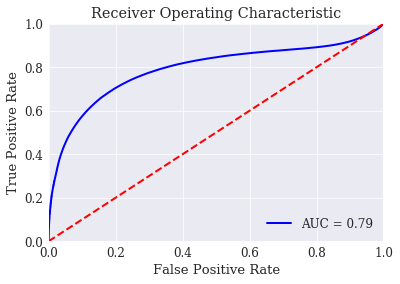

In [87]:
preds = pred_array
fpr, tpr, threshold = metrics.roc_curve(test_array, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()